# **Detección de Caras (real or fake) en PyTorch**

**Objetivo:** modelo de clasificación basado en una CNN para distinguir entre imágenes de rostros reales y fake

**Kaggle**  
https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection/code?datasetId=105271&sortBy=voteCount
https://www.kaggle.com/code/tusharpadhy/real-fake-face-classification-and-visualization/notebook

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/  
https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

In [5]:
# --- pytorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision.utils as vutils
from torchsummary import summary

# --- otras

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

#da MNIST
import torch.nn.functional as F
#df

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cuda para entrenar


In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
img=cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face/training_fake/easy_199_1100.jpg')
folder = "/content/gdrive/MyDrive/Colab Notebooks/" #real_and_fake_face/training_fake
print(folder)

if os.path.exists(folder):
    print("Il percorso esiste.")
    #print(os.listdir(folder))
    #for entry in (os.listdir(folder)):
        #print(entry)
else:
    print("Il percorso non esiste.")



/content/gdrive/MyDrive/Colab Notebooks/
Il percorso esiste.


In [9]:
DATASET = os.path.join(folder, 'real_and_fake_face') # esto puede cambiar dependiendo de donde se ejecute el notebook
INITIAL_SIZE_OF_IMAGES = (128, 128)
print(DATASET)

/content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face


# Explora Sample Images de Dataset

In [6]:
# IMAGE SAMPLE
# https://www.kaggle.com/code/tusharpadhy/real-fake-face-classification-and-visualization/notebook

def load_img(path):
    '''Loading images from directory
    and changing color space from cv2 standard BGR to RGB
    for better visualization'''
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

/content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face/training_real/real_00077.jpg


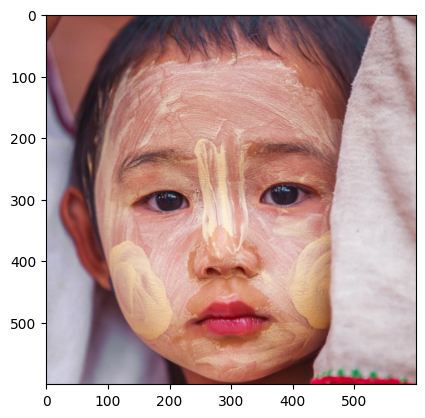

In [7]:
real_dir = os.path.join(DATASET,'training_real')
real_path = os.listdir(real_dir)
#print(real_path)
print(real_dir + '/' + real_path[0])
plt.figure()
plt.imshow(load_img(real_dir + '/' + real_path[15]))
plt.show()

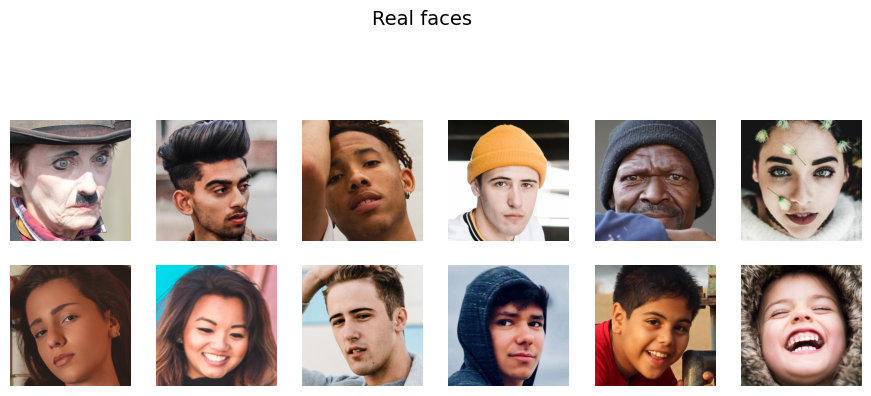

In [8]:
fig = plt.figure(figsize=(11, 11))

for i in range(12):
    plt.subplot(6, 6, i+1)
    plt.imshow(load_img(real_dir + '/' +  real_path[i]))
    plt.suptitle("Real faces", fontsize=14)
    plt.axis('off')

# Divide los datos en conjuntos de entrenamiento y prueba.

In [9]:
#transforma size de imagenes, convierte en tensor, normaliza
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [10]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
#carga datos
full_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)
print(full_dataset)

#train, test y validation
train_size = int(0.8 * len(full_dataset)) # 80% para entrenamiento
test_size = int(0.1 * len(full_dataset)) # 10% test
valid_size = len(full_dataset) - (train_size+test_size) #100-(80+10) = c.ca 10% para validación

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size,test_size])

#dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

print(len(train_dataset[0][0]))
print(train_dataset[0][1])   #label

Dataset ImageFolder
    Number of datapoints: 2041
    Root location: /content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
3
0


In [11]:
#print(train_loader[0])
print(train_size)
print(valid_size)
print(test_size)

1632
205
204


# Model 1

In [ ]:
#RAFF = Real And Fake Faces

class RAFF_CNN(nn.Module):
    def __init__(self):
        super(RAFF_CNN, self).__init__()

        # Primera capa convolucional: 1 canal de entrada (escala de grises),
        # 32 canales de salida, kernel de 3x3, padding de 1 para mantener el tamaño
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Segunda capa convolucional: 32 canales de entrada, 64 canales de salida
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)


        # Capa de pooling: reduce a la mitad el tamaño de la imagen
        self.pool = nn.MaxPool2d(2, 2)


        # Capa fully-conected: la imagen es 7x7 después de dos pooling,
        # y 64 canales, así que 7*7*64 entradas y, por ejemplo, 128 salidas
        self.fc1 = nn.Linear(32*32*64, 128)

        # Capa completamente conectada final: 128 entradas y 2 salidas (clases del 0 al 1, masculino-feminino-fake-real)
        self.fc2 = nn.Linear(128, 2)

        # Capa de dropout para reducir el overfitting
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # Pasar x a través de las capas convolucionales y las funciones de activación ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Aplanar la imagen para la capa completamente conectada
        x = x.view(-1, 32*32*64)

        # Pasar a través de las capas completamente conectadas con ReLU y dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # No se usa activación aquí porque se usará nn.CrossEntropyLoss()

        return x

In [ ]:
# Crear una instancia de la red
model = RAFF_CNN().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

RAFF_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Crea un'istanza del modello
#model = RAFF_CNN()

# Stampa un riepilogo del modello
summary(model, (3, 256, 256))  # Input shape: (canali, altezza, larghezza)
#(3, 256, 256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Linear-5                  [-1, 128]       8,388,736
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 8,408,386
Trainable params: 8,408,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 30.00
Params size (MB): 32.08
Estimated Total Size (MB): 62.83
----------------------------------------------------------------


## Training 1


In [ ]:
num_epochs = 10

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.9628, Train Acc: 51.90%, Valid Loss: 0.6900, Valid Acc: 53.17%
Epoch [2/10], Train Loss: 0.6915, Train Acc: 53.12%, Valid Loss: 0.6892, Valid Acc: 53.17%
Epoch [3/10], Train Loss: 0.6862, Train Acc: 56.31%, Valid Loss: 0.6745, Valid Acc: 53.66%
Epoch [4/10], Train Loss: 0.6692, Train Acc: 59.38%, Valid Loss: 0.7005, Valid Acc: 51.22%
Epoch [5/10], Train Loss: 0.6482, Train Acc: 63.24%, Valid Loss: 0.6694, Valid Acc: 57.07%
Epoch [6/10], Train Loss: 0.6286, Train Acc: 65.87%, Valid Loss: 0.6545, Valid Acc: 56.10%
Epoch [7/10], Train Loss: 0.6045, Train Acc: 68.75%, Valid Loss: 0.6647, Valid Acc: 58.54%
Epoch [8/10], Train Loss: 0.5881, Train Acc: 68.38%, Valid Loss: 0.6423, Valid Acc: 58.54%
Epoch [9/10], Train Loss: 0.5625, Train Acc: 72.00%, Valid Loss: 0.6648, Valid Acc: 55.61%
Epoch [10/10], Train Loss: 0.5295, Train Acc: 72.86%, Valid Loss: 0.6609, Valid Acc: 56.59%
Entrenamiento finalizado!


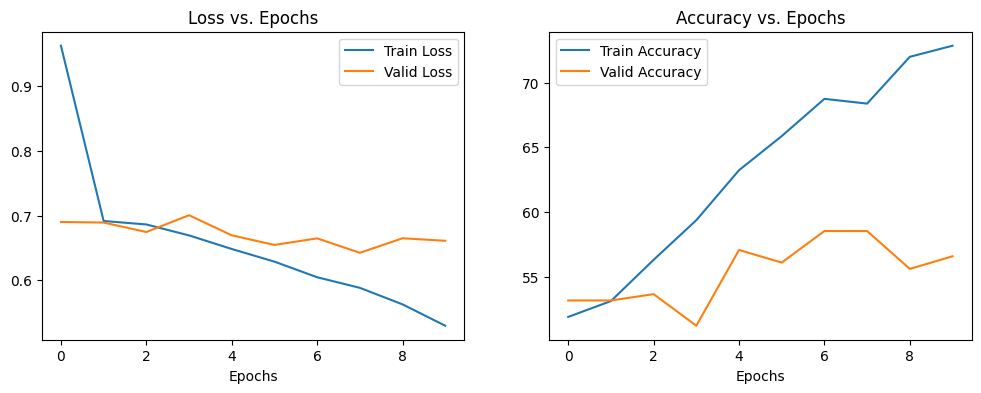

In [ ]:
# Graficar accuracy y loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
model.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        # pasar al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        ############################
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las ... imágenes de prueba: {100 * correct / total}%')

Precisión del modelo en las ... imágenes de prueba: 56.86274509803921%


In [ ]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

Confusion Matrix
[[59 41]
 [47 57]]


In [ ]:
# Metricas
print('Classification Report')
print(metrics.classification_report(y_true, y_pred, target_names=full_dataset.classes))

Classification Report
               precision    recall  f1-score   support

training_fake       0.56      0.59      0.57       100
training_real       0.58      0.55      0.56       104

     accuracy                           0.57       204
    macro avg       0.57      0.57      0.57       204
 weighted avg       0.57      0.57      0.57       204



# Modelo 2.1

In [13]:
#RAFF2 = Real And Fake Faces 2, con mas capas conv

class RAFF2_CNN(nn.Module):
    def __init__(self):
        super(RAFF2_CNN, self).__init__()

        # Primera capa convolucional: 3 canales de entrada (rgb),
        # 64 canales de salida, kernel de 3x3, padding de 1 para mantener el tamaño
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)

        # Segunda capa convolucional: 64 canales de entrada, 128 canales de salida
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 32 * 32, 512) # Supponendo che l'output della convoluzione sia 16x16 con 256 canali
        #self.fc1 = nn.Linear(256 * 8 * 8, 512)

        self.fc2 = nn.Linear(512, 2)

        # Capa de dropout para reducir el overfitting
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        #print(x.shape)
        # Pasar x a través de las capas convolucionales y las funciones de activación ReLU

        #x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.batch_norm1(self.conv1(x)))               # non faccio il max pooling --> faccia batch normalization
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.batch_norm2(self.conv3(x)))               #batch normalization
        x = self.pool(self.dropout(F.relu(self.conv4(x))))
        #print(x.shape)

        # Aplanar la imagen para la capa completamente conectada
        x = x.view(-1, 32*32*256)

        # Pasar a través de las capas completamente conectadas con ReLU y dropout
        x = self.dropout(F.relu(self.fc1(x)))                                     #dropout
        x = self.fc2(x)  # No se usa activación aquí porque se usará nn.CrossEntropyLoss()
        #print(x.shape)
        return x



In [14]:
# Crear una instancia de la red
model2 = RAFF2_CNN().to(device)
print(model2)
#criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model2.parameters(), lr=1)


RAFF2_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:
# Crea un'istanza del modello
#model2 = RAFF2_CNN()
#model2 = model2.to(device)

# Stampa un riepilogo del modello
summary(model2, (3, 256, 256))  # Input shape: (canali, altezza, larghezza)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 64, 256, 256]          18,496
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
       BatchNorm2d-6        [-1, 128, 128, 128]             256
            Conv2d-7        [-1, 256, 128, 128]         295,168
           Dropout-8        [-1, 256, 128, 128]               0
         MaxPool2d-9          [-1, 256, 64, 64]               0
           Linear-10                  [-1, 512]     134,218,240
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 134,608,002
Trainable params: 134,608,002
Non-trainable params: 0
-----------------------

## Training 2

In [ ]:
num_epochs = 20

train_losses = []
avg_train_losses = []
valid_losses = []
avg_valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #print(images)
        labels = labels.to(device)
        #print(labels)

        outputs = model2(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(training_loss)
    avg_train_losses.append(avg_train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model2.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model2(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    avg_valid_losses.append(avg_valid_loss)

    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}],  Train Loss: {training_loss:.4f}, Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {valid_loss:.4f} ,Avg Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model2.train()

print("Entrenamiento finalizado!")

Epoch [1/20],  Train Loss: 168.1274, Avg Train Loss: 9.8898, Train Acc: 49.20%, Valid Loss: 2.0850 ,Avg Valid Loss: 0.6950, Valid Acc: 50.73%
Epoch [2/20],  Train Loss: 11.7798, Avg Train Loss: 0.6929, Train Acc: 52.08%, Valid Loss: 2.0964 ,Avg Valid Loss: 0.6988, Valid Acc: 50.73%
Epoch [3/20],  Train Loss: 11.7933, Avg Train Loss: 0.6937, Train Acc: 53.25%, Valid Loss: 2.0934 ,Avg Valid Loss: 0.6978, Valid Acc: 51.71%
Epoch [4/20],  Train Loss: 11.7102, Avg Train Loss: 0.6888, Train Acc: 53.74%, Valid Loss: 2.1190 ,Avg Valid Loss: 0.7063, Valid Acc: 51.22%
Epoch [5/20],  Train Loss: 11.7278, Avg Train Loss: 0.6899, Train Acc: 54.72%, Valid Loss: 2.1329 ,Avg Valid Loss: 0.7110, Valid Acc: 50.73%
Epoch [6/20],  Train Loss: 11.8341, Avg Train Loss: 0.6961, Train Acc: 55.76%, Valid Loss: 2.1807 ,Avg Valid Loss: 0.7269, Valid Acc: 50.24%
Epoch [7/20],  Train Loss: 11.6302, Avg Train Loss: 0.6841, Train Acc: 56.19%, Valid Loss: 2.1705 ,Avg Valid Loss: 0.7235, Valid Acc: 45.85%
Epoch [8/20]

In [ ]:
print(avg_train_losses)
print( len(avg_train_losses))
avg_train_losses_copy = avg_train_losses.copy()
del avg_train_losses_copy[0]
print(avg_train_losses_copy)
print(len(avg_train_losses_copy))

avg_valid_losses_copy = avg_valid_losses.copy()
del avg_valid_losses_copy[0]



[9.889848870389601, 0.6929268836975098, 0.6937208140597624, 0.6888334084959591, 0.6898712165215436, 0.6961255073547363, 0.6841279128018547, 0.686924134983736, 0.8636689501650193, 0.7214148254955516, 0.6489293154548196, 0.6419051429804634, 0.625322724089903, 0.5837220584644991, 0.5854573249816895, 0.5435260884902057, 0.5065551593023188, 0.4261583808590384, 0.4204449530910043, 0.5155567842371324]
20
[0.6929268836975098, 0.6937208140597624, 0.6888334084959591, 0.6898712165215436, 0.6961255073547363, 0.6841279128018547, 0.686924134983736, 0.8636689501650193, 0.7214148254955516, 0.6489293154548196, 0.6419051429804634, 0.625322724089903, 0.5837220584644991, 0.5854573249816895, 0.5435260884902057, 0.5065551593023188, 0.4261583808590384, 0.4204449530910043, 0.5155567842371324]
19


## Evaluation

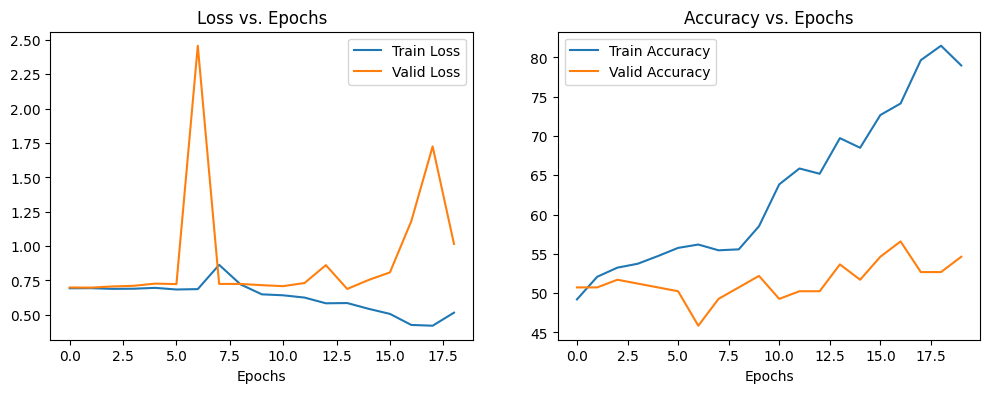

In [ ]:
# Graficar el accuracy y el loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses_copy, label='Train Loss')
plt.plot(avg_valid_losses_copy, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
model2.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        # pasar al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        ############################
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las ... imágenes de prueba: {100 * correct / total}%')

Precisión del modelo en las ... imágenes de prueba: 53.431372549019606%


In [ ]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

Confusion Matrix
[[46 44]
 [51 63]]


In [ ]:
# Metricas
print('Classification Report')
print(metrics.classification_report(y_true, y_pred, target_names=full_dataset.classes))

Classification Report
               precision    recall  f1-score   support

training_fake       0.47      0.51      0.49        90
training_real       0.59      0.55      0.57       114

     accuracy                           0.53       204
    macro avg       0.53      0.53      0.53       204
 weighted avg       0.54      0.53      0.54       204



# Modelo 2.2
### Utiliza técnicas de aumento de datos para mejorar el rendimiento del modelo.

In [11]:
# Librerias
from torch.utils.data import DataLoader, ConcatDataset

# Define the data augmentation transformations
data_transforms1 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7))]),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

DATASET = os.path.join(folder, 'real_and_fake_face') # esto puede cambiar dependiendo de donde se ejecute el notebook
INITIAL_SIZE_OF_IMAGES = (128, 128)
print(DATASET)

full_train_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)

# Create augmented datasets
augmented_images1 = datasets.ImageFolder(root=DATASET, transform=data_transforms1)
augmented_images2 = datasets.ImageFolder(root=DATASET, transform=data_transforms1)
augmented_images3 = datasets.ImageFolder(root=DATASET, transform=data_transforms1)

combined_dataset = ConcatDataset([full_train_dataset, augmented_images1, augmented_images2, augmented_images3])

train_size = int(0.8 * len(combined_dataset))
valid_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_size)
print(valid_size)
print(test_size)

/content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face
6531
816
817


## Entrenamiento con augmented data:

In [ ]:
num_epochs = 30

train_losses = []
avg_train_losses = []
valid_losses = []
avg_valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #print(images)
        labels = labels.to(device)
        #print(labels)

        outputs = model2(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(training_loss)
    avg_train_losses.append(avg_train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model2.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model2(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    avg_valid_losses.append(avg_valid_loss)

    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}],  Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Avg Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model2.train()

print("Entrenamiento finalizado!")

Epoch [1/30],  Avg Train Loss: 1.9473, Train Acc: 52.63%, Avg Valid Loss: 0.6938, Valid Acc: 51.84%
Epoch [2/30],  Avg Train Loss: 0.7120, Train Acc: 52.30%, Avg Valid Loss: 0.6882, Valid Acc: 55.64%
Epoch [3/30],  Avg Train Loss: 0.6941, Train Acc: 52.38%, Avg Valid Loss: 0.6877, Valid Acc: 56.00%
Epoch [4/30],  Avg Train Loss: 0.7044, Train Acc: 52.84%, Avg Valid Loss: 0.6873, Valid Acc: 56.13%
Epoch [5/30],  Avg Train Loss: 0.6917, Train Acc: 52.92%, Avg Valid Loss: 0.6899, Valid Acc: 55.64%
Epoch [6/30],  Avg Train Loss: 0.6978, Train Acc: 53.73%, Avg Valid Loss: 0.6914, Valid Acc: 56.00%
Epoch [7/30],  Avg Train Loss: 0.7010, Train Acc: 56.32%, Avg Valid Loss: 0.6773, Valid Acc: 59.31%
Epoch [8/30],  Avg Train Loss: 0.6780, Train Acc: 59.58%, Avg Valid Loss: 0.6640, Valid Acc: 61.76%
Epoch [9/30],  Avg Train Loss: 0.6669, Train Acc: 61.81%, Avg Valid Loss: 0.6427, Valid Acc: 63.11%
Epoch [10/30],  Avg Train Loss: 0.6610, Train Acc: 62.55%, Avg Valid Loss: 0.6552, Valid Acc: 64.71%

In [ ]:
# Graficar el accuracy y el loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
print(avg_train_losses)
print( len(avg_train_losses))
avg_train_losses_copy = avg_train_losses.copy()
del avg_train_losses_copy[0]
print(avg_train_losses_copy)
print(len(avg_train_losses_copy))

avg_valid_losses_copy = avg_valid_losses.copy()
del avg_valid_losses_copy[0]

In [ ]:
# Graficar el accuracy y el loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses_copy, label='Train Loss')
plt.plot(avg_valid_losses_copy, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

In [ ]:
# Metricas
print('Classification Report')
print(metrics.classification_report(y_true, y_pred, target_names=full_dataset.classes))

# Transfer Learning

## Feature Based

In [37]:
from torchvision import models, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from torch.optim.lr_scheduler import StepLR

DATASET = os.path.join(folder, 'real_and_fake_face') # esto puede cambiar dependiendo de donde se ejecute el notebook
INITIAL_SIZE_OF_IMAGES = (128, 128)
print(DATASET)

/content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face


In [16]:


# Configurar transformaciones para las imágenes de dataset para adaptarlas a Fine Tuning
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224
    transforms.Grayscale(num_output_channels=3),  # Convertir a 3 canales
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Dividir el conjunto de entrenamiento en entrenamiento y validación
#carga datos
full_dataset = datasets.ImageFolder(root=DATASET, transform=transform)
print(full_dataset)

#train, test y validation
train_size = int(0.8 * len(full_dataset)) # 80% para entrenamiento
test_size = int(0.1 * len(full_dataset)) # 10% test
valid_size = len(full_dataset) - (train_size+test_size) #100-(80+10) = c.ca 10% para validación

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size,test_size])

#dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)



Dataset ImageFolder
    Number of datapoints: 2041
    Root location: /content/gdrive/MyDrive/Colab Notebooks/real_and_fake_face
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [17]:
#print(train_loader[0])
print(train_size)
print(valid_size)
print(test_size)

1632
205
204


In [21]:
# Cargar el modelo VGG16 preentrenado y congelar todas las capas convolucionales
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.7MB/s]


In [22]:
# Congelar el entrenamiento para todas las capas "features"
for param in vgg16.features.parameters():
    param.requires_grad = False

In [23]:
# Remover las capas fully connected originales de VGG16
vgg16.classifier = torch.nn.Identity()

In [24]:
# Verificar si CUDA está disponible y usarlo si es posible
vgg16 = vgg16.to(device)

In [25]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# Extracción de características
def extract_features(data_loader, model):
    model.eval()  # Poner el modelo en modo de evaluación
    features = []
    labels = []

    with torch.no_grad():  # Desactivar gradientes para velocidad
        for inputs, target in data_loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.extend(output.cpu().numpy())
            labels.extend(target.numpy())

    return np.array(features), np.array(labels)

In [27]:
# Extracción de características para entrenamiento y pruebas
train_features, train_labels = extract_features(train_loader, vgg16)
test_features, test_labels = extract_features(test_loader, vgg16)

In [30]:
# Entrenar un random forest con las características extraídas
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf.fit(train_features, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [33]:
# Hacer predicciones con la rf entrenada
predicted = rf.predict(test_features)

# Reporte de clasificación
print(classification_report(test_labels, predicted))
print("Accuracy:", accuracy_score(test_labels, predicted))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60       103
           1       0.61      0.71      0.66       101

    accuracy                           0.63       204
   macro avg       0.64      0.63      0.63       204
weighted avg       0.64      0.63      0.63       204

Accuracy: 0.6323529411764706


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


##Fine Tuning

In [48]:
resnet18 = models.resnet18(pretrained=True)

In [40]:
for param in resnet18.parameters():
    param.requires_grad = False

In [41]:
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
)

In [42]:
# Mover el modelo al dispositivo disponible (GPU o CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [45]:
num_epochs = 30

train_losses = []
avg_train_losses = []
valid_losses = []
avg_valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #print(images)
        labels = labels.to(device)
        #print(labels)

        outputs = resnet18(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(training_loss)
    avg_train_losses.append(avg_train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    resnet18.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    avg_valid_losses.append(avg_valid_loss)

    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}],  Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Avg Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    resnet18.train()

print("Entrenamiento finalizado!")

Epoch [1/30],  Avg Train Loss: 0.7007, Train Acc: 53.37%, Avg Valid Loss: 0.6838, Valid Acc: 60.00%
Epoch [2/30],  Avg Train Loss: 0.6822, Train Acc: 56.74%, Avg Valid Loss: 0.6723, Valid Acc: 60.00%
Epoch [3/30],  Avg Train Loss: 0.6675, Train Acc: 59.93%, Avg Valid Loss: 0.6459, Valid Acc: 61.95%
Epoch [4/30],  Avg Train Loss: 0.6645, Train Acc: 60.11%, Avg Valid Loss: 0.6294, Valid Acc: 62.44%
Epoch [5/30],  Avg Train Loss: 0.6458, Train Acc: 61.89%, Avg Valid Loss: 0.6695, Valid Acc: 63.41%
Epoch [6/30],  Avg Train Loss: 0.6321, Train Acc: 64.52%, Avg Valid Loss: 0.6134, Valid Acc: 62.93%
Epoch [7/30],  Avg Train Loss: 0.6316, Train Acc: 65.50%, Avg Valid Loss: 0.6441, Valid Acc: 64.88%
Epoch [8/30],  Avg Train Loss: 0.6196, Train Acc: 65.01%, Avg Valid Loss: 0.6108, Valid Acc: 62.93%
Epoch [9/30],  Avg Train Loss: 0.6295, Train Acc: 64.09%, Avg Valid Loss: 0.6625, Valid Acc: 62.44%
Epoch [10/30],  Avg Train Loss: 0.6180, Train Acc: 66.05%, Avg Valid Loss: 0.6685, Valid Acc: 61.46%

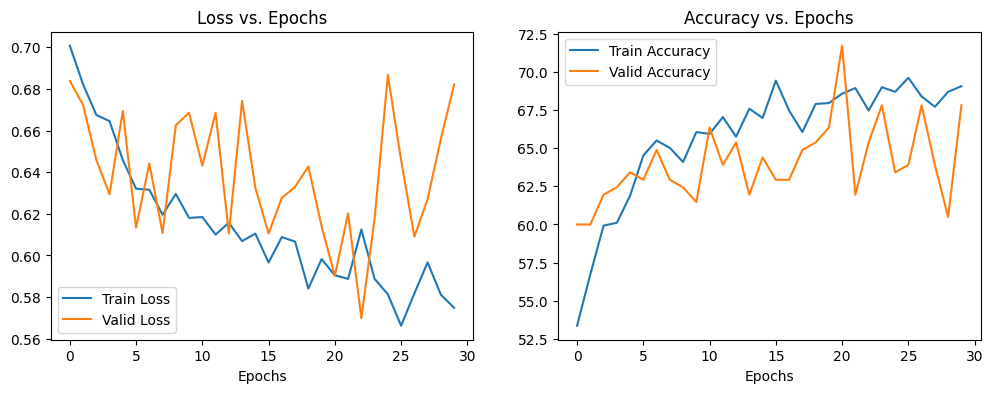

In [53]:
# Graficar el accuracy y el loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [54]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same